# Goal

`f(image, class_id, effect_id) --> image_with_effect_on_class_segments`

```python
def f1(image, class_id, effect_id):
    """One way to implement f"""
    image_with_global_effect = apply_effect_to_entire_image(image, effect_id)
    local_region = get_local_region(image, class_id)
    image_with_local_effect = apply_effect_to_subimage(image,
                                                       image_with_global_effect,
                                                       local_region)
    return image_with_local_effect
```

    # V1: Trained on ImageNet 20k, 288x288, black borders, JH's cropped Van Gogh image
        # Training:
            # lr=1e-3, batch_size=8, nb_epoch=2
            # lr=1e-4, batch_size=16, nb_epoch=1
        # Try with more images
        # Try with bigger images
        # Try with center cropping instead
        # Try a different training procedure

### Setup

#### Change this to your deephacks repo path

In [1]:
INPUT_DIR = '/nbs/deephacks/' 

### Low-level functions

#### Visualization functions

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def plots(ims, figsize=(12,6), rows=1, cols=1, interp=None, titles=None, cmap=None):
    fig = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = fig.add_subplot(rows, cols, i+1)
        interp_i = interp[i] if interp else None
        if titles: sp.set_title(titles[i], fontsize=18)
        cmap_i = cmap[i] if cmap else None
        plt.imshow(ims[i], interpolation=interp, cmap=cmap_i)
        plt.axis('off')

#### Segmentation functions

In [3]:
from scipy.misc import imsave
import os
import numpy as np
from PIL import Image
from IPython import embed
from model import get_frontend, add_softmax, add_context
from utils import interp_map, pascal_palette
from keras.preprocessing.image import load_img, img_to_array

ZOOM = 8
MEAN = [102.93, 111.36, 116.52]
PASCAL_PALETTE = {
    0: (0, 0, 0),
    1: (128, 0, 0),
    2: (0, 128, 0),
    3: (128, 128, 0),
    4: (0, 0, 128),
    5: (128, 0, 128),
    6: (0, 128, 128),
    7: (128, 128, 128),
    8: (64, 0, 0),
    9: (192, 0, 0),
    10: (64, 128, 0),
    11: (192, 128, 0),
    12: (64, 0, 128),
    13: (192, 0, 128),
    14: (64, 128, 128),
    15: (192, 128, 128),
    16: (0, 64, 0),
    17: (128, 64, 0),
    18: (0, 192, 0),
    19: (128, 192, 0),
    20: (0, 64, 128),
}

CATEGORIES = {
        'aeroplane': 1,
        'bicycle': 2,
        'bird': 3,
        'boat': 4,
        'bottle': 5,
        'bus': 6,
        'car': 7,
        'cat': 8,
        'chair': 9,
        'cow': 10,
        'diningtable': 11,
        'dog': 12,
        'horse': 13,
        'motorbike': 14,
        'person': 15,
        'pottedplant': 16,
        'sheep': 17,
        'sofa': 18,
        'train': 19,
        'tvmonitor': 20
}

# Settings for the Pascal dataset
input_width, input_height = 900, 900
label_margin = 186
has_context_module = False

def get_trained_model():
    """ Returns a model with loaded weights. """

    model = get_frontend(input_width, input_height)

    if has_context_module:
        model = add_context(model)

    model = add_softmax(model)

    def load_tf_weights():
        """ Load pretrained weights converted from Caffe to TF. """

        # 'latin1' enables loading .npy files created with python2
        weights_data = np.load(SEGMENTATION_WEIGHTS_PATH, encoding='latin1').item()

        for layer in model.layers:
            if layer.name in weights_data.keys():
                layer_weights = weights_data[layer.name]
                layer.set_weights((layer_weights['weights'],
                                   layer_weights['biases']))

    def load_keras_weights():
        """ Load a Keras checkpoint. """
        model.load_weights(SEGMENTATION_WEIGHTS_PATH)

    if SEGMENTATION_WEIGHTS_PATH.endswith('.npy'):
        load_tf_weights()
    elif SEGMENTATION_WEIGHTS_PATH.endswith('.hdf5'):
        load_keras_weights()
    else:
        raise Exception("Unknown weights format.")

    return model


def forward_pass(image):
    ''' Runs a forward pass to segment the image. '''

    model = get_trained_model()

    # Load image and swap RGB -> BGR to match the trained weights
    image_rgb = image.astype(np.float32)
    image = image_rgb[:, :, ::-1] - MEAN
    image_size = image.shape

    # Network input shape (batch_size=1)
    net_in = np.zeros((1, input_height, input_width, 3), dtype=np.float32)

    output_height = input_height - 2 * label_margin
    output_width = input_width - 2 * label_margin

    # This simplified prediction code is correct only if the output
    # size is large enough to cover the input without tiling
    try:
        assert image_size[0] < output_height
        assert image_size[1] < output_width
    except:
        print("Max output hight and width:", output_height-1, output_width-1)
        print("Current output_height and output_width", image_size)
        raise Exception("Assertion error")

    # Center pad the original image by label_margin.
    # This initial pad adds the context required for the prediction
    # according to the preprocessing during training.
    image = np.pad(image,
                   ((label_margin, label_margin),
                    (label_margin, label_margin),
                    (0, 0)), 'reflect')

    # Add the remaining margin to fill the network input width. This
    # time the image is aligned to the upper left corner though.
    margins_h = (0, input_height - image.shape[0])
    margins_w = (0, input_width - image.shape[1])
    image = np.pad(image,
                   (margins_h,
                    margins_w,
                    (0, 0)), 'reflect')

    # Run inference
    net_in[0] = image
    prob = model.predict(net_in)[0]

    # Reshape to 2d here since the networks outputs a flat array per channel
    prob_edge = np.sqrt(prob.shape[0]).astype(np.int)
    prob = prob.reshape((prob_edge, prob_edge, 21))

    # Upsample
    if ZOOM > 1:
        prob = interp_map(prob, ZOOM, image_size[1], image_size[0])

    # Recover the most likely prediction (actual segment class)
    prediction = np.argmax(prob, axis=2)
    # Apply the color palette to the segmented image
    color_image = np.array(pascal_palette)[prediction.ravel()].reshape(
        prediction.shape + (3,))
    return prediction, color_image

Using TensorFlow backend.


#### Style transfer functions

In [4]:
import numpy as np
np.random.seed(8675309)
import tensorflow as tf
from keras.models import Model
from keras.layers import Layer, Input, InputSpec, Lambda, Convolution2D, BatchNormalization, Activation, UpSampling2D, merge
import keras.backend as K

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
        
    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')
    
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

def res_crop_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1), 'valid')
    x = conv_block(x,  nf, 3, (1,1), 'valid', False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return merge([x, ip], mode='sum')

def up_block(x, filters, size):
    x = UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

def make_mixer(mixer_input):
    c = 2 # Number of conv blocks and up blocks
    r = 5 # Number of res blocks
    r2 = r * 8 # Amount of reflection padding
    nf = 64
    x = ReflectionPadding2D((r2, r2))(mixer_input)
    x = conv_block(x, nf, 9, (1,1))
    for i in range(c): x = conv_block(x, nf, 3)
    for i in range(r): x = res_crop_block(x, nf)
    for i in range(c): x = up_block(x, nf, 3)
    x = Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
    mixer_output = Lambda(lambda x: (x+1)*127.5)(x)
    return Model(mixer_input, mixer_output, name="mixer")

### Medium-level functions

In [5]:
def load_mixer(shape, effect_id="van_gogh", version="1"):
    weights_dir = WEIGHTS_DIR + effect_id + "/"
    mixer_input = Input(shape, name="mixer_input")
    mixer = make_mixer(mixer_input)
    mixer.load_weights(weights_dir + f'v{version}.h5')
    return mixer

### High-level functions

In [25]:
from PIL import Image, ImageFilter
from scipy.misc import imsave
from time import time
    
def show_results(image, class_id, effect_id="van_gogh", foreground=True, opacity=0.80, blur=True):
    """The highest level function."""
    start = time()
    image = np.array(image)
    start_1 = time()
    try:
        mask = np.array(Image.open(MASK_FILE))
    except IOError:
        mask = get_local_region(image, class_id)
    print("get_local_region:", time() - start_1, "seconds")
    start_2 = time()
    stylized_global = apply_effect_to_entire_image(image, effect_id)[0]
    print("apply_effect_to_entire_image:", time() - start_2, "seconds")
    start_3 = time()
    result = apply_effect_to_subimage(image, stylized_global, mask, foreground, opacity, blur)
    print("apply_effect_to_subimage:", time() - start_3, "seconds")
    # Save
    parameters = ['', effect_id, class_id, str(foreground), str(opacity)]
    results_path = OUTPUT_PREFIX + '_'.join(parameters) + ".png"
    start_4 = time()
    imsave(results_path, result)
    print("imsave:", time() - start_4, "seconds")
    print("Saved to:", results_path)
    # Plots
    imgs = [image, stylized_global, mask]
    plots(imgs, figsize=(12, 12), rows=1, cols=3, cmap=[None, None, "gray"])
    plots([result], figsize=(8, 8), rows=1, cols=1);
    print("show_results:", time() - start)

def get_local_region(image, class_id):
    # Get segments of all classes
    pred, color_image = forward_pass(image)
    #Change all pixels != our target category to 0 (black)
    pred[pred != CATEGORIES[class_id]] = 0
    #Change all pixels == our target category to 1 (white)
    pred[pred == CATEGORIES[class_id]] = 1
    # Save image locally
    imsave(MASK_FILE, pred)
    print('Saved to:', MASK_FILE)
    return pred
    
def apply_effect_to_entire_image(images, effect_id="van_gogh"):
    """Applies an effect to a list of images."""
    if type(images) == list:
        images = np.array(images)
    elif type(images) == np.ndarray and len(images.shape) < 4:
        images = np.expand_dims(images, 0)
    shape = images[0].shape
    if effect_id in ["van_gogh", "scream", "okeffe"]:
        mixer = load_mixer(shape, effect_id, version="1")
        raw_results = mixer.predict(images)
        images_with_global_effect = [np.round(raw_result).astype('uint8') for raw_result in raw_results]
    elif effect_id == "black":
        images_with_global_effect = [np.zeros(shape)]
    else:
        raise Exception("Unrecognized effect id")
    return images_with_global_effect
    
def apply_effect_to_subimage(image, image_with_global_effect, mask, foreground, opacity, blur):
    pil_mask = Image.fromarray(mask.astype('uint8'))
    if blur:
        pil_mask = pil_mask.filter(ImageFilter.BLUR)
    pil_image = Image.fromarray(image)
    pil_image_with_global_effect = Image.fromarray(image_with_global_effect)
    if pil_image_with_global_effect.size != pil_image:
        print("Error: Image size mismatch?")
        print("Sizes:", pil_image_with_global_effect.size, pil_image.size)
        print("######### Forcing a resize.")
        pil_image_with_global_effect = pil_image_with_global_effect.resize(pil_image.size)
    if foreground:
        final_image = Image.composite(pil_image_with_global_effect, pil_image, pil_mask)
    else:
        final_image = Image.composite(pil_image, pil_image_with_global_effect, pil_mask)
    final_image = Image.blend(pil_image, final_image, opacity)
    return final_image

### Highest-level API so far

get_local_region: 0.0005407333374023438 seconds
apply_effect_to_entire_image: 1.7077007293701172 seconds
Error: Image size mismatch?
Sizes: (316, 316) (315, 316)
######### Forcing a resize.
apply_effect_to_subimage: 0.009465932846069336 seconds
imsave: 0.03983187675476074 seconds
Saved to: /nbs/deephacks/results/dog_okeffe_dog_True_0.8.png
show_results: 1.9089410305023193


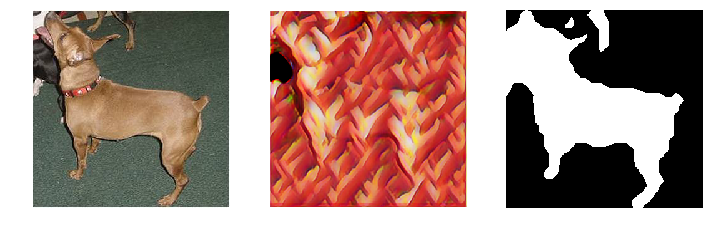

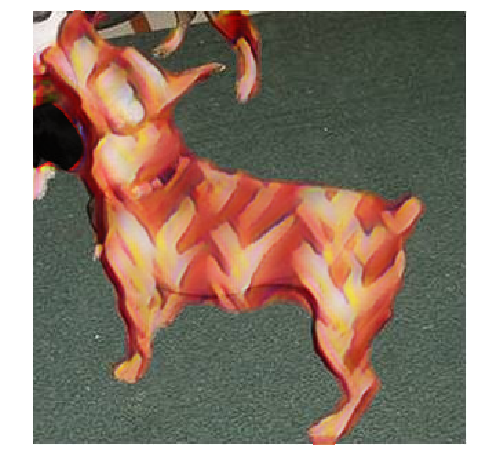

In [26]:
WEIGHTS_DIR = INPUT_DIR + "weights/"
SEGMENTATION_WEIGHTS_PATH = INPUT_DIR + 'conversion/dilation8_pascal_voc.npy'

RESULTS_DIR = INPUT_DIR + 'results/'
IMAGES_DIR = 'images/'
OUTPUT_DIR = IMAGES_DIR + 'segmentations/'

TEST_PHOTO_FILENAME = 'images/dog.10010.jpg'.split(IMAGES_DIR)[-1]

INPUT_FILE = IMAGES_DIR + TEST_PHOTO_FILENAME
MASK_FILE = OUTPUT_DIR + TEST_PHOTO_FILENAME + '_seg.png'
OUTPUT_PREFIX = RESULTS_DIR + TEST_PHOTO_FILENAME.split('.')[0]

image = Image.open(INPUT_FILE)

show_results(image, class_id="dog", effect_id="okeffe", foreground=True, opacity=.8)